In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops, regionprops_table
from scipy import interpolate
import scipy.fftpack

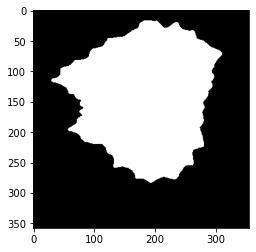

In [2]:
#Load image
I = cv2.imread(r'a1.jpg')
I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
th, bw = cv2.threshold(I, 0, 255, cv2.THRESH_OTSU)
plt.imshow(I,cmap='gray')
nx,ny = I.shape

#perimeter of particle
contours, hierarchy = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

#Centroids
M = cv2.moments(contours[0])
cx = int(M['m10']/M['m00']) 
cy = int(M['m01']/M['m00'])

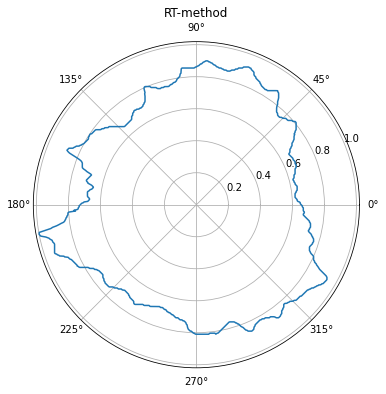

In [3]:
#RT_Method
xp=[]
yp=[]
rho=[]
phi=[]
for i in range(len(contours[0])):
    #Perimeter-centroids measure 
    xp.append(contours[0][i][0][0]-cx)
    yp.append(contours[0][i][0][1]-cy)
    #Cartesian to polar
    rho.append (np.sqrt(xp[i]**2 + yp[i]**2))
    phi.append(np.arctan2(yp[i], xp[i]))

#Resample
#Ensures that the sample size is the same
N=1024 # Number of samplepoints
f = interpolate.interp1d(phi, rho)
phi_resampled = np.linspace(np.min(phi), np.max(phi), N)
rho_resampled  = f(phi_resampled)
rho_resampled =rho_resampled /np.max(rho_resampled )
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection': 'polar'})
ax.plot(phi_resampled, rho_resampled )
ax.grid(True)
ax.set_title("RT-method")
plt.show()

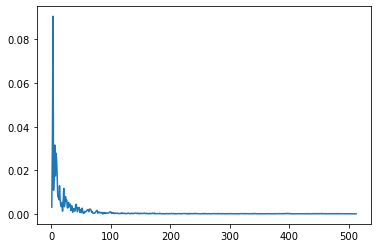

In [4]:
# Fourier transform 
# sample spacing
T = 1.0 / N
x = np.linspace(0.0, N*T, N)
yf = scipy.fftpack.fft(rho_resampled)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

#To plot, DC or mean is discarded
fig, ax = plt.subplots()
ax.plot(xf[1:], 2.0/N * np.abs(yf[1:N//2]))
plt.show()

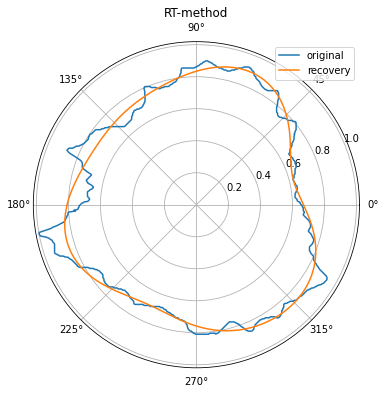

In [5]:
#Inverse FFT
# Shape recovery discarding harmonics
Nr=5 # number of harmonics to shape recovery 
yfr=yf*0
yfr[0]=yf[0]
yfr[1:Nr+1]=yf[1:Nr+1]
yfr[-Nr:]=yf[-Nr:]
rho_recovery = scipy.fft.ifft(yfr)
rho_recovery=np.abs(rho_recovery)


fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection': 'polar'})
ax.plot(phi_resampled, rho_resampled, label='original' )
ax.plot(phi_resampled, rho_recovery, label='recovery')
ax.grid(True)
ax.set_title("RT-method")
ax.legend()
plt.show()